# Приоритизация гипотез для увеличения выручки интернет-магазина и анализ A/B-теста

В распоряжении данные интернет-магазина с информацией о заказах, о времени совершения заказа и размере выручки.\
Данные о выдвинутых гипотезах: краткое описание, охват пользователей, влияние на пользователей, оценка уверенности в гипотезе и затраты ресурсов на проверку гипотезы. \
И данные о группах A/B-теста.

Задача — приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

**Описание данных**\
*Первый датасет, в дальнейшем `hypothesis`:*

Hypothesis — краткое описание гипотезы;\
Reach — охват пользователей по 10-балльной шкале;\
Impact — влияние на пользователей по 10-балльной шкале;\
Confidence — уверенность в гипотезе по 10-балльной шкале;\
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.\

*Второй датасет с данными по заказам, в дальнешйем `orders_df`:*

transactionId — идентификатор заказа;\
visitorId — идентификатор пользователя, совершившего заказ;\
date — дата, когда был совершён заказ;\
revenue — выручка заказа;\
group — группа A/B-теста, в которую попал заказ.


*Третий дасат с данными по визитам по группам A/B-теста, в дальнейшем `visitors`:*

date — дата;\
group — группа A/B-теста;\
visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

# Оглавление

1. [Предобработка данных](#start)\
   [Выводы по блоку знакомства и предобработки](#conclusion_one)
2. [Приоритизация гипотез](#hypothesis)\
   2.1 [Применение фреймворка ICE для приоритизации гипотез](#hypothesis_ICE)\
   2.2 [Применение фреймворка RICE для приоритизации гипотез](#hypothesis_RICE)\
   [Выводы по блоку приоритизация гипотез](#conclusion_hypothesis)
3. [Анализ A/B-теста](#A/B_test)\
   3.1 [Подготовка данных](#preparation)\
   3.2 [График кумулятивной выручки по группам](#two)\
   3.3 [График кумулятивного среднего чека по группам](#three)\
   3.4 [График относительного изменения кумулятивного среднего чека группы B к группе A](#four)\
   3.5 [График кумулятивного среднего количества заказов на посетителя по группам](#five)\
   3.6 [График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A](#six)\
   3.7 [График количества заказов по пользователям](#seven)\
   3.8 [Расчет 95-ого и 99-ого перцентилей количества заказов на пользователя](#eight)\
   3.9 [График стоимостей заказов](#nine)\
   3.10 [Расчет 95-ого и 99-ого перцентилей стоимости заказов](#ten)\
   3.11 [Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным](#eleven)\
   3.12 [Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#twelve)\
   3.13 [Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным](#thirteen)\
   3.14 [Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#fourteen)
4. [Вывод](#conclusion)

<a id="start"></a> 
### Предобработка данных

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
pd.set_option('max_colwidth', 120)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
hypothesis.columns = hypothesis.columns.str.lower()

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
orders_df = pd.read_csv('/datasets/orders.csv')

In [6]:
orders_df.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
orders_df.columns = orders_df.columns.str.lower()

In [8]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   int64 
 1   visitorid      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
orders_df['date'] = orders_df['date'].map(lambda x: dt.datetime.strptime(str(x), '%Y-%m-%d'))

Проверим на дубликаты:

In [10]:
orders_df.duplicated().sum()

0

In [11]:
orders_df[orders_df[['transactionid', 'visitorid']].duplicated(keep=False)]

,transactionid,visitorid,date,revenue,group


Проверим не попали ли какие-то пользователи в обе группы:

In [12]:
goroup_A_orders = orders_df[orders_df['group'] == 'A']
goroup_B_orders = orders_df[orders_df['group'] == 'B']

In [13]:
visitorid_A = set(goroup_A_orders['visitorid'].unique())
visitorid_B = set(goroup_B_orders['visitorid'].unique())

In [14]:
visitorid_A_and_B = (visitorid_A & visitorid_B)
len(visitorid_A_and_B)

58

In [15]:
orders = orders_df[np.logical_not(orders_df['visitorid'].isin(visitorid_A_and_B))]
orders

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


In [16]:
visitors = pd.read_csv('/datasets/visitors.csv')

In [17]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [18]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [19]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(str(x), '%Y-%m-%d'))

Проверим на дубликаты:

In [20]:
visitors.duplicated().sum()

0

Проверим относительное различие количества пользователей по группам.

In [21]:
goroup_A = visitors[visitors['group'] == 'A']
goroup_B = visitors[visitors['group'] == 'B']
print(goroup_A['visitors'].sum())
print(goroup_B['visitors'].sum())

18736
18916


In [22]:
1-goroup_A['visitors'].sum()/goroup_B['visitors'].sum()

0.009515753859166809

- Относительное различие количества пользователей по группам составляет меньше 1%.

<a id="conclusion_one"></a> 
**Вывод**\
Данные по трем датасетам выгружены корректны. Пропусков в данных нет. Тип данных по столбцам с датами измнен на соответствующий.

<a id="hypothesis"></a> 
### Приоритизация гипотез

In [23]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<a id="hypothesis_ICE"></a> 
#### Применение фреймворка ICE для приоритизации гипотез

In [24]:
pd.set_option('max_colwidth', 50)
hypothesis['ICE'] = round((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'], 2)
print(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)) 

                                          hypothesis    ICE
8  Запустить акцию, дающую скидку на товар в день...  16.20
0  Добавить два новых канала привлечения трафика,...  13.33
7  Добавить форму подписки на все основные страни...  11.20
6  Показать на главной странице баннеры с актуаль...   8.00
2  Добавить блоки рекомендаций товаров на сайт ин...   7.00
1  Запустить собственную службу доставки, что сок...   2.00
5  Добавить страницу отзывов клиентов о магазине,...   1.33
3  Изменить структура категорий, что увеличит кон...   1.12
4  Изменить цвет фона главной страницы, чтобы уве...   1.00


- Наиболее перспективные гипотезы по ICE под номерами: 8, 0, 7.

<a id="hypothesis_RICE"></a> 
#### Применение фреймворка RICE для приоритизации гипотез

In [25]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'] 
print(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                          hypothesis   RICE
7  Добавить форму подписки на все основные страни...  112.0
2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
0  Добавить два новых канала привлечения трафика,...   40.0
6  Показать на главной странице баннеры с актуаль...   40.0
8  Запустить акцию, дающую скидку на товар в день...   16.2
3  Изменить структура категорий, что увеличит кон...    9.0
1  Запустить собственную службу доставки, что сок...    4.0
5  Добавить страницу отзывов клиентов о магазине,...    4.0
4  Изменить цвет фона главной страницы, чтобы уве...    3.0


- Наиболее перспективная гипотеза по RICE под номером 7, так же: 2, 0, 6.

<a id="conclusion_hypothesis"></a> 
**Вывод**\
Показатель ICE рассчитываетс по трем компонентам: Impact — насколько сильно изменение повлияет на охваченных пользователей, Confidence — насколько уверены, что это изменение повлияет на пользователей именно так и компонент Efforts — сколько стоит протестировать эту гипотезу.\
Показатель RICE отличается от ICE тем, что в расчет RICE входит еще компонент Reach - количество потенциальных пользователей, которых затронит изменение.\
По ICE самые перспективные гипотезы вышли под номерами: 8, 0, 7.\
При расчете с Reach, а именно по RICE самая перспективная вышла гипотеза под номером 7, так как у нее парметр Reach (охват пользователей) равен оценке 10 и он выше, чем у остальных гипотез. Гипотеза под номером 8 по значению ICE выше остальных, а по RICE на 5-ом месте, так же из-за ее параметра Reach - он у нее самый низкий из всех и равен 1. Охват важен. по 8-ой гипотезе предполагается наименьшее количество потенциальных пользователей. В приоритете гипотеза 7 и 0.\
Первой рекомендую протестировать гипотезу 7 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". По данной гипотезе наивысшая оценка потенциального охвата пользователей, выше среднего оценки влияния на охваченнх пользоваталей, и уверенности, что измненеие повлияет, при этом оценка затрат составляет среднюю отметку 5.




<a id="A/B_test"></a> 
### Анализ A/B-теста

<a id="preparation"></a> 
#### Подготовка данных

In [26]:
order_groups = orders[['date', 'group']].drop_duplicates()

In [27]:
orders_aggregated = order_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'transactionid': 'nunique', 'visitorid': 'nunique', 'revenue': 'sum',}),
    axis=1,
).sort_values(by=['date', 'group'])

In [28]:
visitors_aggregated = order_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

In [29]:
cumulative = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulative.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative['conversion'] = cumulative['orders']/cumulative['visitors']

In [30]:
print(cumulative['date'].max() == orders['date'].max())
print(cumulative['date'].max() == visitors['date'].max())

True
True


In [31]:
print(cumulative['date'].min() == orders['date'].min())
print(cumulative['date'].min() == visitors['date'].min())

True
True


In [32]:
cumulative_A = cumulative[cumulative['group']=='A']

cumulative_B = cumulative[cumulative['group']=='B']

<a id="two"></a> 
#### График кумулятивной выручки по группам

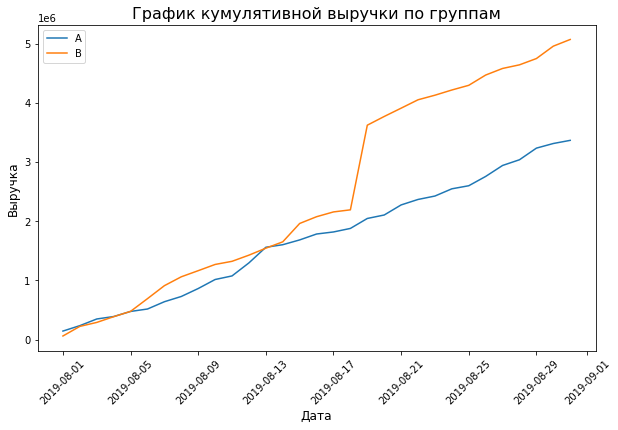

In [33]:
plt.figure(figsize=(10, 6))

plt.title('График кумулятивной выручки по группам', fontsize=16)

plt.plot(cumulative_A['date'], cumulative_A['revenue'], label='A')

plt.plot(cumulative_B['date'], cumulative_B['revenue'], label='B')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Выручка', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.show()

- Обе группы первые 12 дней теста поднимались равномеро. На третьей недели группа B сильно вырвалась вперед, и дальше обе группы расли равномерно по кумулятивной выручки. Возможной причиной могут быть аномальные значения в группе B.

<a id="three"></a> 
#### График кумулятивного среднего чека по группам

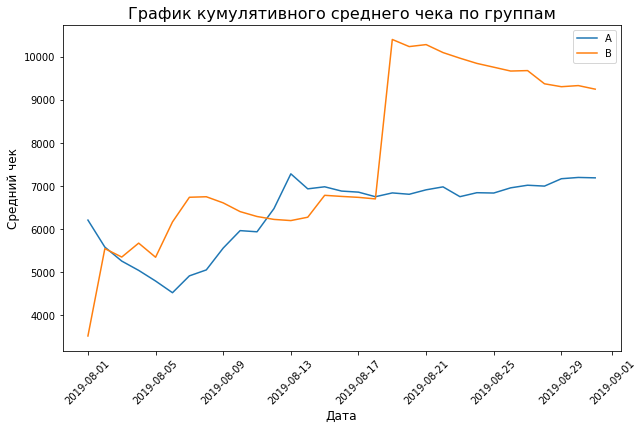

In [34]:
plt.figure(figsize=(10, 6))
plt.title('График кумулятивного среднего чека по группам', fontsize=16)
plt.plot(cumulative_A['date'], cumulative_A['revenue']/cumulative_A['orders'], label='A')
plt.plot(cumulative_B['date'], cumulative_B['revenue']/cumulative_B['orders'], label='B')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Средний чек', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.show()

- Кумулятивное значение среднечго чека колеблеться по двум группам первые 2,5 недели теста, так же по группе B сильное колебание видно на третьей недели теста. К концу теста кумулятивные значение среднечго чека по обеим группах становится более стабильным.

<a id="four"></a> 
#### График относительного изменения кумулятивного среднего чека группы B к группе A

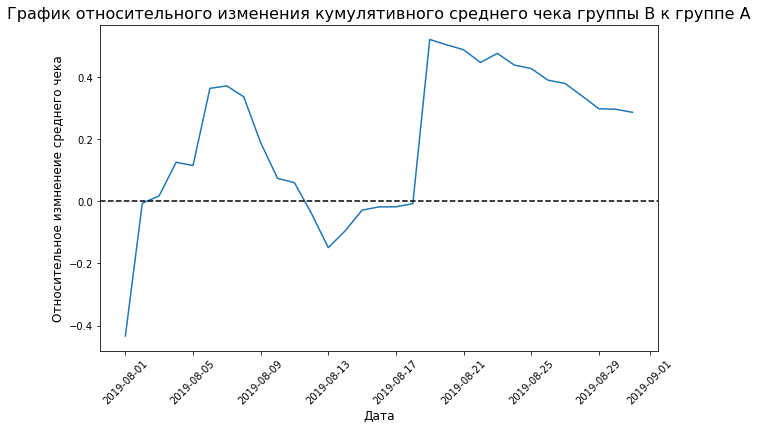

In [35]:
plt.figure(figsize=(10, 6))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=16)
merged_cumulative_revenue = cumulative_A.merge(cumulative_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Относительное измненеие среднего чека', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

- Результаты теста резко менялись в несколько дат, вероятно повлияли аномальные значения. Но в основном группа B стабильно лучше группы A по кумулятивному значению среднего чека.

<a id="five"></a> 
#### График кумулятивного среднего количества заказов на посетителя по группам

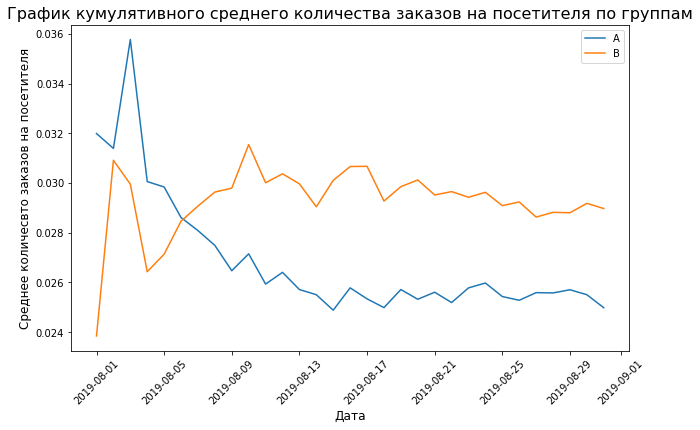

In [36]:
plt.figure(figsize=(10, 6))
plt.title('График кумулятивного среднего количества заказов на посетителя по группам', fontsize=16)
plt.plot(cumulative_A['date'], cumulative_A['conversion'], label='A')
plt.plot(cumulative_B['date'], cumulative_B['conversion'], label='B')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Среднее количесвто заказов на посетителя', fontsize=12)
plt.xticks(rotation=45)
plt.legend() 
plt.show()

- В начале теста среднее количество заказов на посетителя группы А было выше, но с 5-ого дняя стала сильно падать, а в группе B стало рости и было стабильно выше группы А. К концу теста среднее количество заказов на посетителя продолжает колебаться, но со стабильным разрывом между группами, где значение В больше А.

<a id="six"></a> 
#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

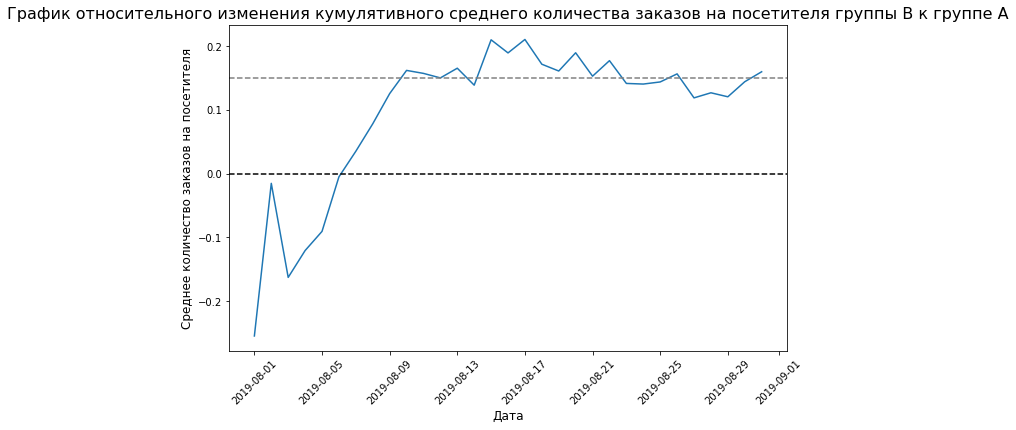

In [37]:
plt.figure(figsize=(10, 6))
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A', fontsize=16)

plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['ordersB']/merged_cumulative_revenue['visitorsB'])/(merged_cumulative_revenue['ordersA']/merged_cumulative_revenue['visitorsA'])-1)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Среднее количество заказов на посетителя', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.show()

- Группа В с 5-ого дня теста стабильно лидирует по конверсии относительно группы А, но с колебаниями. К концу теста конверсия группы В имеет прирост относительно группы А в 15%.

<a id="seven"></a> 
#### График количества заказов по пользователям

In [38]:
orders_buyers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'})
)
orders_buyers.columns = ['buyers', 'orders']

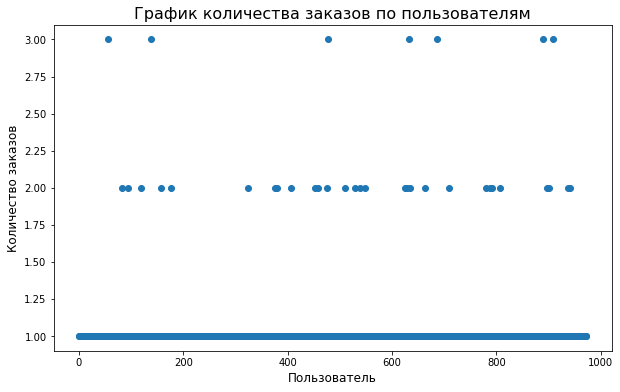

In [39]:
plt.figure(figsize=(10, 6))
plt.title('График количества заказов по пользователям', fontsize=16)
x = pd.Series(range(0, len(orders_buyers)))
plt.scatter(x, orders_buyers['orders'])
plt.xlabel('Пользователь', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.show()

- По точечному графику видно, что в основном пользователи совершали 1 заказ. 2 заказа по графику совершали значительно меньше, но на выбросы больше похоже количество заказов от 3 и выше. Проверим перцентили.

<a id="eight"></a> 
#### Расчет 95-ого и 99-ого перцентилей количества заказов на пользователя

In [40]:
np.percentile(orders_buyers['orders'], [95, 99])

array([1., 2.])

- Больше 1-ого заказа совершали не более 5% пользователей, и больше 2 заказов не более 1% пользователей. Границей для определения аномальных значений обозначим не больше 1-ого заказа.

<a id="nine"></a> 
#### График стоимостей заказов

In [41]:
orders.sort_values(by='revenue', ascending=False).head(10)

,transactionid,visitorid,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A
949,1347999392,887908475,2019-08-21,60450,A
940,2420050534,4003628586,2019-08-08,58550,B
131,3163614039,2254586615,2019-08-22,53904,A


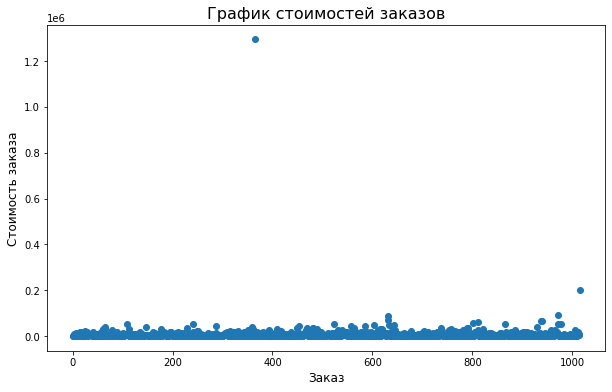

In [42]:
plt.figure(figsize=(10, 6))
plt.title('График стоимостей заказов', fontsize=16)
x = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x, orders['revenue']) 
plt.xlabel('Заказ', fontsize=12)
plt.ylabel('Стоимость заказа', fontsize=12)
plt.show()

Построим второй график, чтобы рассмотреть ближе стоимость заказов без больших выбросов.

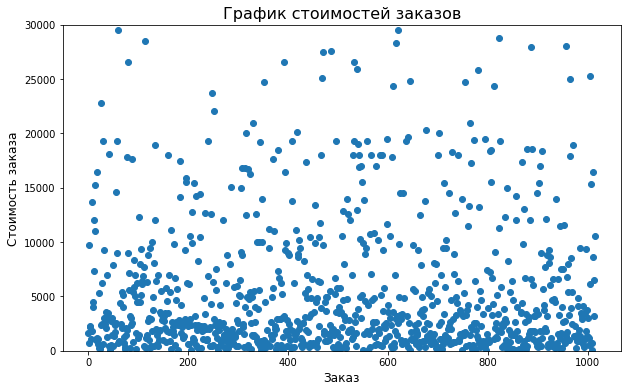

In [43]:
plt.figure(figsize=(10, 6))
plt.title('График стоимостей заказов', fontsize=16)
x = pd.Series(range(0, len(orders['revenue'])))
plt.ylim(0, 30000) 
plt.scatter(x, orders['revenue']) 
plt.xlabel('Заказ', fontsize=12)
plt.ylabel('Стоимость заказа', fontsize=12)

plt.show()

- По первому точечному графику стоимостей заказов видно, что есть значительные выбросы в районе 200000 рублей и более 1,2 млн рублей. Так же заказов за 100000 рублей немного. На втором графике заказов дороже 10000 рублей становится все меньше, и выше 25000 рублей заказы совсем редкие.  Проверим перцентили.

<a id="ten"></a> 
#### Расчет 95-ого и 99-ого перцентилей стоимости заказов

In [44]:
np.percentile(orders['revenue'], [90, 95, 99])


array([17990., 26785., 53904.])

- Не более, чем у 5% заказов чеки дорожи 26785 рублей, и у не более 1% заказов чеки больше 53904 рублей. Границей для определения аномальных значений обозначим заказы не дороже 26785 рублей.

<a id="eleven"></a> 
#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

- **Нулевая гипотеза:** статистически значимых различий в среднем количетсве заказов на посетителя между группами по "сырым" данным нет.
- **Альтернативная гпиотеза:** статистически значимые различия в среднем количетсве заказов на посетителя между группами по "сырым" данным есть.
- **Уровень статистической значимости:** alpha = 0.05.
- **Метод проверки:** применим статистический критерий Манна-Уитни, так как по нему можно сравнить две независимые выборки по уровню какого-либо количественно измеренного критерия и понять разницу.

In [45]:
visitors_daily_A = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_A.columns = ['date', 'visitors_per_date_A']

In [46]:
visitors_daily_B = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_B.columns = ['date', 'visitors_per_date_B']

In [47]:
orders_daily_A = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_A.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

In [48]:
orders_daily_B = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_B.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

In [49]:
data = (
    orders_daily_A.merge(
        orders_daily_B, left_on='date', right_on='date', how='left'
    )
    .merge(visitors_daily_A, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_B, left_on='date', right_on='date', how='left')
)


In [50]:
orders_buyers_A = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
orders_buyers_A.columns = ['buyers', 'orders']


orders_buyers_B = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
orders_buyers_B.columns = ['buyers', 'orders'] 


sample_A = pd.concat([orders_buyers_A['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - len(orders_buyers_A['orders'])), name='orders')],axis=0)

sample_B = pd.concat([orders_buyers_B['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - len(orders_buyers_B['orders'])), name='orders')],axis=0)


print('P-value по среднему количеству заказаов на посетителя между группами по "сырым" данным:', "{0:.5f}".format(stats.mannwhitneyu(sample_A, sample_B)[1]))

print('Разница между группами A и B по среднему количеству заказаов на посетителя по "сырым" данным:', "{0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

P-value по среднему количеству заказаов на посетителя между группами по "сырым" данным: 0.01102
Разница между группами A и B по среднему количеству заказаов на посетителя по "сырым" данным: 0.160


- P-value меньше 0.05 - в среднем количестве заказов на посетител между группами есть статистически значимые различия. Относительный прирост среднего группы В к среднему количеству заказов на посетителя группы А равен 16.0%. Нужно сравнить метрики без аномальных значений.
- Нулевую гипотезу отвергаем - статистически значимые различия в среднем количестве заказов на посетителя между группами по "сырым" данным есть.

<a id="twelve"></a> 
#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

- **Нулевая гипотеза:** статистически значимых различий в среднем чеке заказа между группами по "сырым" данным нет.
- **Альтернативная гпиотеза:** статистически значимые различия в среднем чеке заказа между группами по "сырым" данным есть.
- **Уровень статистической значимости:** alpha = 0.05.
- **Метод проверки:** применим статистический критерий Манна-Уитни, так как по нему можно сравнить две независимые выборки по уровню какого-либо количественно измеренного критерия и понять разницу.

In [51]:
print('P-value по среднему чеку заказа между группами по "сырым" данным:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Разница между группами A и B по среднему чеку заказа по "сырым" данным:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value по среднему чеку заказа между группами по "сырым" данным: 0.829
Разница между группами A и B по среднему чеку заказа по "сырым" данным: 0.287


- P-value значительно больше 0.05 - в среднем размере чека между группами нет статистически значимых различий. Но относительное различие среднего чека между группами В и А равен 28.7%. Так же стоит сравнить метрики без аномальных значений.
- Нулевую гипотезу не отвергаем, статистически значимых различий в среднем чеке заказа между группами по "сырым" данным нет. Однако группа В лидирует на 28,7%.

<a id="thirteen"></a> 
#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

- **Нулевая гипотеза:** статистически значимых различий в среднем количетсве заказов на посетителя между группами по "очищенным" данным нет.
- **Альтернативная гпиотеза:** статистически значимые различия в среднем количетсве заказов на посетителя между группами по "очищенным" данным есть.
- **Уровень статистической значимости:** alpha = 0.05.
- **Метод проверки:** применим статистический критерий Манна-Уитни, так как по нему можно сравнить две независимые выборки по уровню какого-либо количественно измеренного критерия и понять разницу.

In [52]:
buyers_with_many_orders = pd.concat(
    [
        orders_buyers_A[orders_buyers_A['orders'] > np.percentile(orders_buyers['orders'], 95)]['buyers'],
        orders_buyers_B[orders_buyers_B['orders'] > np.percentile(orders_buyers['orders'], 95)]['buyers'],
    ],
    axis=0,
)
buyers_with_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitorid']

abnormal_buyers = (
    pd.concat([buyers_with_many_orders, buyers_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [53]:
sample_A_purified = pd.concat(
    [
        orders_buyers_A[
            np.logical_not(orders_buyers_A['buyers'].isin(abnormal_buyers))
        ]['orders'],
        pd.Series(0, index=np.arange(
                data['visitors_per_date_A'].sum() - len(orders_buyers_A['orders'])
            ), name='orders')
    ],
    axis=0,
)



In [54]:
sample_B_purified = pd.concat(
    [
        orders_buyers_B[
            np.logical_not(orders_buyers_B['buyers'].isin(abnormal_buyers))
        ]['orders'],
        pd.Series(0, index=np.arange(
                data['visitors_per_date_B'].sum() - len(orders_buyers_B['orders'])
            ), name='orders')
    ],
    axis=0,
)

In [55]:
print('P-value по среднему количеству заказаов на пользователя между группами по "очищенным" данным:', '{0:.5f}'.format(stats.mannwhitneyu(sample_A_purified, sample_B_purified)[1]))
print('Разница между группами A и B по среднему количеству заказаов на пользователя по "очищенным" данным:', '{0:.3f}'.format(sample_B_purified.mean()/sample_A_purified.mean()-1)) 


P-value по среднему количеству заказаов на пользователя между группами по "очищенным" данным: 0.01593
Разница между группами A и B по среднему количеству заказаов на пользователя по "очищенным" данным: 0.174


- Как и по "сырым" данным, по отфильтрованным, P-value меньше 0.05 - есть статистически значимые различия. Относительный прирост среднего группы В к среднему количеству заказов на посетителя группы А равен 17,4%. 
- Нулевую гипотезу отвергаем, статистически значимые различия в среднем количестве заказов на посетителя между группами по "очищенным" данным есть.

<a id="fourteen"></a> 
#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

- **Нулевая гипотеза:** статистически значимых различий в среднем чеке заказа между группами по "очищенным" данным нет.
- **Альтернативная гпиотеза:** статистически значимые различия в среднем чеке заказа между группами по "очищенным" данным есть.
- **Уровень статистической значимости:** alpha = 0.05.
- **Метод проверки:** применим статистический критерий Манна-Уитни, так как по нему можно сравнить две независимые выборки по уровню какого-либо количественно измеренного критерия и понять разницу.

In [56]:
print('P-value по среднему чеку заказа между группами по "очищенным" данным:', '{0:.3f}'.format(stats.mannwhitneyu(
                orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorid'].isin(abnormal_buyers)),
                )]['revenue'], 
                orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorid'].isin(abnormal_buyers)),
                )]['revenue'])[1])
     )

print('Разница между группами A и B по среднему чеку заказа по "очищенным" данным:', "{0:.3f}".format(
                orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorid'].isin(abnormal_buyers)),
                )]['revenue'].mean()
               / orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorid'].isin(abnormal_buyers)),
            )]['revenue'].mean()- 1)
)

P-value по среднему чеку заказа между группами по "очищенным" данным: 0.727
Разница между группами A и B по среднему чеку заказа по "очищенным" данным: -0.034


- P-value так же больше 0.05, как и по "сырым" данным, и составляет 72,7% - в среднем размере чека заказа между группами нет статистически значимых различий.
- Нулевую гипотезу не отвергаем, статистически значимых различий в среднем чеке заказа между группами по "сырым" данным нет. Но поменялась лидирующая группа - А стала незначтительно лидировать над В - на 3,4%.

<a id="conclusion"></a> 
### Вывод

В распоряжении были данные трех датасетов с данными о выдвинутах гипотизах, данными о заказах и с данными деления пользователей на группы для A/B-теста.

Проведены следущие шаги:
1. Выгрузка данных, проверка и предобработка.
2. Применение фреймворков для приоритизации гипотез.
3. Анализ A/B-теста.

По результатам анализа A/B-теста выделены следующие наблюдения:
- По графикам кумулятивных данных: по среднему количеству заказов на посетителя и среднему чеку заказа группа B лидирует над A;
- Есть статистически значимые различия по среднему количеству заказов между группами и по «сырым» данным и по данным после удаления аномалий: группа B показывает прирост среднего количества заказов на посетителя над группой А.
- Нет статистически значимого различия по среднему чеку заказа между группами ни по «сырым», ни по данным после удаления аномалий;
- Графики различий среднего чека заказа и среднего количества заказов на посетителя, показывают, что результаты группы B стабилизируются к окончанию теста и стабильно выше, чем у группы А.

По данным наблюдениям считаю, что предположительно лучше принять решение об остановке теста и зафиксировать победу группы B над A.